# Modern graph storage with dgraph

## When do you need a graph database?

- Connected data
- Order of items not as important as their interconnection
- Additional/Optional attributes being added later on.
- Efficient retrieval of hierarchical data

## Nodes & edge

In graph databases there usually exist two primary means to model data:

- nodes
- edges that connect nodes

Nodes can either hold a value themselves or simply act as connection point for additional "value" edges.


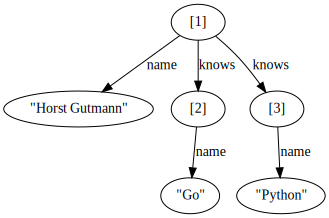

In [172]:
import graphviz

g = graphviz.Digraph()
g.edge('[1]', '"Horst Gutmann"', label='name')
g.edge('[1]', '[2]', label='knows')
g.edge('[2]', '"Go"', label='name')
g.edge('[1]', '[3]', label='knows')
g.edge('[3]', '"Python"', label='name')
g

Think of edges as "properties". In the previous example, the graph said that "Horst Gutmann" knows "Go" and "Python". "Go" and "Python" are themselves generic nodes that just have the respective name assigned to them.

As you can see, "[1]" can have multiple edges with the same name to different target nodes. This is not possible for properties linking to "value nodes" like the string "Horst Gutmann". So, "[1]" can only have a single "name".

## Data-Triple

You might think of data inside the graph simply as a collection of triples.

```
<person:1> <name> "Horst Gutmann"
<person:1> <knows> <concept:2>
<concept:2> <name> "Go"
<concept:3> <name> "Python"
<person:1> <knows> <concept:3>
```

In fact, this format was used for the "Semantic Web"'s RDF standard. Here you always have a Subject, a Predicate, and an Object. `<person:1>` would be an identifier for the node, `<name>` is the predicate, and `"Horst Gutmann"` the string value.

Before we continue, let's make our dataset a bit more interesting by adding some languages to the mix:

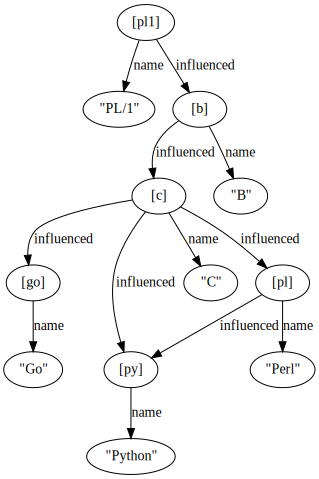

In [173]:
import graphviz

g = graphviz.Digraph()
g.edge('[go]', '"Go"', label='name')
g.edge('[pl1]', '"PL/1"', label='name')
g.edge('[py]', '"Python"', label='name')
g.edge('[c]', '"C"', label='name')
g.edge('[b]', '"B"', label='name')
g.edge('[pl]', '"Perl"', label='name')
g.edge('[pl1]', '[b]', label='influenced')
g.edge('[b]', '[c]', label='influenced')
g.edge('[c]', '[go]', label='influenced')
g.edge('[c]', '[py]', label='influenced')
g.edge('[c]', '[pl]', label='influenced')
g.edge('[pl]', '[py]', label='influenced')
g

## Triple stores

Storing triples into a "normal" relational database shouldn't be that hard of a problem. Table with 3 columns and you're done. 

Let's imagine now, that you want to get a list of all the people that know languages that were inspired by Perl and B. Relational databases are very bad when it comes to hierarchical queries.

Graph databases shine here! You might be surprised, how much information would make so much more sense being modelled as graphs instead of tables with numerical identifiers "linking" them 🤷‍♂️

## Install dgraph

dgraph initially consists of usually 3 processes:

1. A process managing the cluster as a whole called "zero".
2. A process representing the first (and single) node in our cluster called "alpha".
3. A process for serving a simple web frontend called "ratel".

To make that easy, let's just work with a docker-compose.yml file:

In [174]:
from IPython.display import display, Code
display(Code(open("docker-compose.yml").read(), language="YAML"))

version: "3.2"
services:
  zero:
    image: dgraph/dgraph:latest
    volumes:
      - type: volume
        source: dgraph
        target: /dgraph
        volume:
          nocopy: true
    ports:
      - 5080:5080
      - 6080:6080
    restart: on-failure
    command: dgraph zero --my=zero:5080
  server:
    image: dgraph/dgraph:latest
    volumes:
      - type: volume
        source: dgraph
        target: /dgraph
        volume:
          nocopy: true
    ports:
      - 8080:8080
      - 9080:9080
    restart: on-failure
    command: dgraph alpha --my=server:7080 --lru_mb=2048 --zero=zero:5080
  ratel:
    image: dgraph/dgraph:latest
    volumes:
      - type: volume
        source: dgraph
        target: /dgraph
        volume:
          nocopy: true
    ports:
      - 8000:8000
    command: dgraph-ratel

volumes:
  dgraph:

Now all you have to do is run...

```
$ docker-compose up
```

## Interaction via HTTP

Most of your interactions with dgraph will most likely happen through its HTTP API. Let's do some housekeeping first:

In [175]:
import requests
from pprint import pprint

# Inside this little registry we will keep track of all the uids we are
# creating:
uid_registry = {}

def query(q, start_ts=None):
    """
    Execute the given query against the server.
    """
    url = 'http://localhost:8080/query'
    if start_ts is not None:
        url = f'{url}?startTs={start_ts}'
    result = requests.post(url, data=q, headers={'Content-Type': 'application/graphql+-'}).json()
    if 'errors' in result and result['errors']:
        raise Exception(result['errors'])
    return result
    
def mutate(req, start_ts=None):
    """
    Helper for running mutation requests against the test server.
    """
    global uid_registry
    url = 'http://localhost:8080/mutate?commitNow=true'
    if start_ts is not None:
        url = f'http://localhost:8080/mutate?startTs={start_ts}'
    result = requests.post(url, data=req, headers={'Content-Type': 'application/rdf'}).json()
    print(result)
    for k, v in result['data']['uids'].items():
        uid_registry[k] = v
    return result

In [176]:
# Let's remove the database:
requests.post('http://localhost:8080/alter', data='{ "drop_all": true }')

<Response [200]>

## Creating data inside a graph

Adding data to a Dgraph instance is basically just specifying triples:

In [177]:
mutate('''{
    set {
        _:pl1 <name> "PL/1" .
        _:go <name> "Go" .
        _:pl <name> "Perl" .
        _:py <name> "Python" .
        _:c <name> "C" .
        _:b <name> "B" .
        _:b <influenced> _:c .
        _:pl1 <influenced> _:b .
        _:c <influenced> _:go .
        _:c <influenced> _:pl .
        _:c <influenced> _:py .
        _:pl <influenced> _:py .
    }
}''')

{'data': {'code': 'Success', 'message': 'Done', 'uids': {'b': '0x45', 'c': '0x4a', 'go': '0x47', 'pl': '0x48', 'pl1': '0x46', 'py': '0x49'}}, 'extensions': {'server_latency': {'parsing_ns': 32800, 'processing_ns': 14994000}, 'txn': {'start_ts': 246, 'commit_ts': 247, 'preds': ['1-influenced', '1-name']}}}


{'data': {'code': 'Success',
  'message': 'Done',
  'uids': {'b': '0x45',
   'c': '0x4a',
   'go': '0x47',
   'pl': '0x48',
   'pl1': '0x46',
   'py': '0x49'}},
 'extensions': {'server_latency': {'parsing_ns': 32800,
   'processing_ns': 14994000},
  'txn': {'start_ts': 246,
   'commit_ts': 247,
   'preds': ['1-influenced', '1-name']}}}

Now that we have data in the database, let's get a list of all the languages that we know about so far:

In [178]:
query('''{
    languages(func:has(name)) {
        uid
        name
    }
}''')

{'data': {'languages': [{'uid': '0x45', 'name': 'B'},
   {'uid': '0x46', 'name': 'PL/1'},
   {'uid': '0x47', 'name': 'Go'},
   {'uid': '0x48', 'name': 'Perl'},
   {'uid': '0x49', 'name': 'Python'},
   {'uid': '0x4a', 'name': 'C'}]},
 'extensions': {'server_latency': {'parsing_ns': 27700,
   'processing_ns': 5030900,
   'encoding_ns': 31100,
   'assign_timestamp_ns': 1278600},
  'txn': {'start_ts': 248}}}

Querying in Dgraph works by finding "root" nodes and then working down through the predicates . In this example above we want a collection of root-nodes called "languages" that have the predicate "name" set.

From these nodes, we want to know their respective name and uid predicate-values.

## Attributes and the schema

Let's try to answer a simple question now: What uid has Go in our database?

In [179]:
try:
    query('''{
        go(func:eq(name, "Go")) {
            uid
        }
    }''')
except Exception as e:
    print(e)

[{'message': ': Attribute name is not indexed.', 'extensions': {'code': 'ErrorInvalidRequest'}}]


Turns out, you can only search based on attributes that are indexed. Basically, whenever you use a predicate for the first time, Dgraph registers it with some default options. Dgraph won't index that attribute by default, though.

Before we can filter based on the "name" attribute, we therefore have to tell Dgraph that it should be indexed:

In [180]:
requests.post('http://localhost:8080/alter', data='''
name: string @index(exact, fulltext) .
''')

<Response [200]>

In [181]:
query('''{
    go(func:eq(name, "Go")) {
        uid
    }
}''')

{'data': {'go': [{'uid': '0x47'}]},
 'extensions': {'server_latency': {'parsing_ns': 625900,
   'processing_ns': 3904600,
   'encoding_ns': 6800,
   'assign_timestamp_ns': 2707400},
  'txn': {'start_ts': 251}}}

## Recursive queries

We can now finally query based on names. One step down. Jumping back to our original quest, let's now try to get a list of all the languages that were influenced by B.

This is where Dgraph begins to shine compared to relational database systems. You can tell it to recurse down all the requested attributes of a node. In our case, we want to recurse down the "influenced" attribute:

In [182]:
query('''{
    query(func:eq(name, "B")) @recurse {
        uid
        name
        influenced
    }
}''')

{'data': {'query': [{'uid': '0x45',
    'name': 'B',
    'influenced': [{'uid': '0x4a',
      'name': 'C',
      'influenced': [{'uid': '0x47', 'name': 'Go'},
       {'uid': '0x48',
        'name': 'Perl',
        'influenced': [{'uid': '0x49', 'name': 'Python'}]},
       {'uid': '0x49', 'name': 'Python'}]}]}]},
 'extensions': {'server_latency': {'parsing_ns': 98700,
   'processing_ns': 8060200,
   'encoding_ns': 53400,
   'assign_timestamp_ns': 1668700},
  'txn': {'start_ts': 252}}}

While we get all the data that we wanted, there are two problems here:

1. The result includes B itself
2. The result is nested.

Can we somehow get to the nodes themselves?

## Query variables

In [183]:
query('''{
    var(func:eq(name, "B")) @recurse {
        L as influenced
    }
    
    influenced(func:uid(L)) {
        uid
        name
    }
}''')

{'data': {'influenced': [{'uid': '0x47', 'name': 'Go'},
   {'uid': '0x48', 'name': 'Perl'},
   {'uid': '0x49', 'name': 'Python'},
   {'uid': '0x4a', 'name': 'C'}]},
 'extensions': {'server_latency': {'parsing_ns': 33900,
   'processing_ns': 4846300,
   'encoding_ns': 27200,
   'assign_timestamp_ns': 1505300},
  'txn': {'start_ts': 253}}}

Here we first did a var-query in order to define some query variables. We mostly did the same query as before, but bound the value of the "influenced" attribute to a variable "L".

In the next query we simply requested all the nodes that matched the content of the variable L.

## Back to the original question

Let's now try to get a list of all the languages that were influenced by both: Perl and B.

In [184]:
query('''{
    var(func:eq(name, "B")) @recurse {
        uid
        name
        B as influenced
    }
    
    var(func:eq(name, "Perl")) @recurse {
        uid
        name
        PERL as influenced 
    }
    
    languages(func:has(name)) @filter(uid(PERL) AND uid(B)) {
        uid
        name
    }
}''')

{'data': {'languages': [{'uid': '0x49', 'name': 'Python'}]},
 'extensions': {'server_latency': {'parsing_ns': 69900,
   'processing_ns': 9458200,
   'encoding_ns': 15100,
   'assign_timestamp_ns': 1198900},
  'txn': {'start_ts': 254}}}

## Inverse edges

So far, we've only followed attributes in one direction: From subject to object.

Let's try to answer the following question with that: "What languages influenced Go?"

In [185]:
query('''{
    languages(func:has(name)) @recurse {
        uid
        name
        influenced @filter(eq(name, "Go"))
    }
}''')

{'data': {'languages': [{'uid': '0x45', 'name': 'B'},
   {'uid': '0x46', 'name': 'PL/1'},
   {'uid': '0x47', 'name': 'Go'},
   {'uid': '0x48', 'name': 'Perl'},
   {'uid': '0x49', 'name': 'Python'},
   {'uid': '0x4a',
    'name': 'C',
    'influenced': [{'uid': '0x47', 'name': 'Go'}]}]},
 'extensions': {'server_latency': {'parsing_ns': 23800,
   'processing_ns': 4954700,
   'encoding_ns': 35300,
   'assign_timestamp_ns': 1143800},
  'txn': {'start_ts': 255}}}

That didn't work out. Wouldn't it be easier if we could walk up the tree based on the "Go" node? For that, we need to make the "influenced" attribute also work in the other direction:

In [186]:
requests.post('http://localhost:8080/alter', data='''
name: string @index(exact, fulltext) .
influenced: [uid] @reverse .
''')

<Response [200]>

In [187]:
query('''{
    languages(func:eq(name, "Go")) @recurse {
        uid
        name
        ~influenced
    }
}''')

{'data': {'languages': [{'uid': '0x47',
    'name': 'Go',
    '~influenced': [{'uid': '0x4a',
      'name': 'C',
      '~influenced': [{'uid': '0x45',
        'name': 'B',
        '~influenced': [{'uid': '0x46', 'name': 'PL/1'}]}]}]}]},
 'extensions': {'server_latency': {'parsing_ns': 36000,
   'processing_ns': 5666500,
   'encoding_ns': 29800,
   'assign_timestamp_ns': 1923800},
  'txn': {'start_ts': 257}}}

## Multi-lingual content

A feature that is often required in modern applications is a way to store data in multiple languages. In Dgraph every string can be stored in multiple languages.

Let's say, we want to store city names in multiple languages. Before doing so, we first have to tell Dgraph that the "name" attribute should support this feature:

In [188]:
requests.post('http://localhost:8080/alter', data='''
name: string @index(exact, fulltext) @lang .
influenced: [uid] @reverse .
''')

<Response [200]>

In [189]:
vienna_uid = mutate('''{
    set {
        _:vienna <name> "Vienna"@en .
        _:vienna <name> "Wien"@de .
    }
}''')['data']['uids']['vienna']

{'data': {'code': 'Success', 'message': 'Done', 'uids': {'vienna': '0x4b'}}, 'extensions': {'server_latency': {'parsing_ns': 19000, 'processing_ns': 13143700}, 'txn': {'start_ts': 259, 'commit_ts': 260, 'preds': ['1-name']}}}


In [190]:
query('''{
    query(func:uid(%s)) {
        uid
        name@de
        name@en
    }
}''' % (vienna_uid))['data']

{'query': [{'uid': '0x4b', 'name@de': 'Wien', 'name@en': 'Vienna'}]}

Please note that there is nothing like a fallback from "name" to "name@en" or "name@de". You have to specify the right language to get to the name of a city:

In [191]:
query('''{
    query(func:uid(%s)) {
        uid
        name
    }
}''' % (vienna_uid))

{'data': {'query': [{'uid': '0x4b'}]},
 'extensions': {'server_latency': {'parsing_ns': 25400,
   'processing_ns': 3286700,
   'encoding_ns': 13400,
   'assign_timestamp_ns': 1545300},
  'txn': {'start_ts': 262}}}

What you can do, though, is request such a fallback mechanism:

In [192]:
# Take first a <name> attribute and then the first language-tagged value if empty:
query('''{
    query(func:uid(%s)) {
        uid
        name@.
    }
}''' % (vienna_uid))

{'data': {'query': [{'uid': '0x4b', 'name@.': 'Vienna'}]},
 'extensions': {'server_latency': {'parsing_ns': 65100,
   'processing_ns': 2976200,
   'encoding_ns': 17500,
   'assign_timestamp_ns': 2406900},
  'txn': {'start_ts': 263}}}

In [193]:
# Take the German value and fall back to the English one if empty:
query('''{
    query(func:uid(%s)) {
        uid
        name@de:en
    }
}''' % (vienna_uid))

{'data': {'query': [{'uid': '0x4b', 'name@de:en': 'Wien'}]},
 'extensions': {'server_latency': {'parsing_ns': 30700,
   'processing_ns': 2871200,
   'encoding_ns': 20200,
   'assign_timestamp_ns': 1233100},
  'txn': {'start_ts': 264}}}

In [194]:
# If you don't care what language should be used after no German language was found, use `de:.`:
query('''{
    query(func:uid(%s)) {
        uid
        name@de:.
    }
}''' % (vienna_uid))

{'data': {'query': [{'uid': '0x4b', 'name@de:.': 'Wien'}]},
 'extensions': {'server_latency': {'parsing_ns': 25800,
   'processing_ns': 3355100,
   'encoding_ns': 30900,
   'assign_timestamp_ns': 1118700},
  'txn': {'start_ts': 265}}}

## Types

We've now operated on two distinction classes of nodes that both have names:

1. Programming languages
2. Cities

How can we distinguish the two?

### Before 1.1

* Before 1.1 there was no concept of types in Dgraph.
* You usually either introduced some kind of `type` attribute
* or used a `is_...` or some other property that makes it clear what type a node has by simply being attached.

In [195]:
mutate('''{
    set {
        <%s> <is_city> "" .
        <%s> <type> "city" .
    }
}''' % (vienna_uid, vienna_uid))

{'data': {'code': 'Success', 'message': 'Done', 'uids': {}}, 'extensions': {'server_latency': {'parsing_ns': 22900, 'processing_ns': 11176600}, 'txn': {'start_ts': 266, 'commit_ts': 267, 'preds': ['1-is_city', '1-type']}}}


{'data': {'code': 'Success', 'message': 'Done', 'uids': {}},
 'extensions': {'server_latency': {'parsing_ns': 22900,
   'processing_ns': 11176600},
  'txn': {'start_ts': 266,
   'commit_ts': 267,
   'preds': ['1-is_city', '1-type']}}}

In [196]:
query('''{
    cities(func:has(is_city)) {
        uid
        name@.
    }
}''')

{'data': {'cities': [{'uid': '0x4b', 'name@.': 'Vienna'}]},
 'extensions': {'server_latency': {'parsing_ns': 69600,
   'processing_ns': 4502000,
   'encoding_ns': 20300,
   'assign_timestamp_ns': 1817800},
  'txn': {'start_ts': 268}}}

### Dgraph >= 1.1

Since version 1.1 you can also define types inside of the schema definition. These can then also be assigned to nodes and queried:

In [197]:
requests.post('http://localhost:8080/alter', data='''
type City {
  name: string @index(exact, fulltext) @lang
}

name: string @index(exact, fulltext) @lang .
influenced: [uid] @reverse .
''')

<Response [200]>

In [198]:
mutate('''{
    set {
        <%s> <dgraph.type> "City" .
    }
}''' % (vienna_uid))

{'data': {'code': 'Success', 'message': 'Done', 'uids': {}}, 'extensions': {'server_latency': {'parsing_ns': 29000, 'processing_ns': 13883600}, 'txn': {'start_ts': 270, 'commit_ts': 271, 'preds': ['1-dgraph.type']}}}


{'data': {'code': 'Success', 'message': 'Done', 'uids': {}},
 'extensions': {'server_latency': {'parsing_ns': 29000,
   'processing_ns': 13883600},
  'txn': {'start_ts': 270, 'commit_ts': 271, 'preds': ['1-dgraph.type']}}}

In [199]:
query('''{
    cities(func:type(City)) {
        uid
        name@.
    }
}''')

{'data': {'cities': [{'uid': '0x4b', 'name@.': 'Vienna'}]},
 'extensions': {'server_latency': {'parsing_ns': 25400,
   'processing_ns': 5938100,
   'encoding_ns': 32000,
   'assign_timestamp_ns': 1832400},
  'txn': {'start_ts': 272}}}

## Transactions

One of the key features of Dgraph is its support for transactions. This allows us to combine multiple read and write operations into transactions and either commit them or roll them back as a whole.

If you're using the HTTP API, then all transaction-handling is done through the `start_ts` query parameter.

In [200]:
data = query('''{
    cities(func:type(City)) {
        uid
        name@.
    }
}''', start_ts=0)
display(data)
txn = data['extensions']['txn']

{'data': {'cities': [{'uid': '0x4b', 'name@.': 'Vienna'}]},
 'extensions': {'server_latency': {'parsing_ns': 25500,
   'processing_ns': 8128300,
   'encoding_ns': 34000,
   'assign_timestamp_ns': 1286100},
  'txn': {'start_ts': 273}}}

In [201]:
mutate('''{
    set {
        _:graz <name> "Graz" .
        _:graz <dgraph.type> "City" .
    }
}''')

query('''{
    cities(func:type(City)) {
        uid
        name@.
    }
}''')

{'data': {'code': 'Success', 'message': 'Done', 'uids': {'graz': '0x4c'}}, 'extensions': {'server_latency': {'parsing_ns': 19500, 'processing_ns': 12216500}, 'txn': {'start_ts': 274, 'commit_ts': 275, 'preds': ['1-dgraph.type', '1-name']}}}


{'data': {'cities': [{'uid': '0x4b', 'name@.': 'Vienna'},
   {'uid': '0x4c', 'name@.': 'Graz'}]},
 'extensions': {'server_latency': {'parsing_ns': 26300,
   'processing_ns': 3468300,
   'encoding_ns': 11900,
   'assign_timestamp_ns': 1129300},
  'txn': {'start_ts': 276}}}

In [202]:
# Inside the transaction that we previously started, Graz doesn't exist yet:
query('''{
    cities(func:type(City)) {
        uid
        name@.
    }
}''', start_ts=txn['start_ts'])

{'data': {'cities': [{'uid': '0x4b', 'name@.': 'Vienna'}]},
 'extensions': {'server_latency': {'parsing_ns': 26800,
   'processing_ns': 982900,
   'encoding_ns': 18500},
  'txn': {'start_ts': 273}}}

In [203]:
# If we now create another city, we see that inside the context of the transaction:
data = mutate('''{
    set {
        _:klagenfurt <name> "Klagenfurt" .
        _:klagenfurt <dgraph.type> "City" .
    }
}''', start_ts=txn['start_ts'])
tnx_state = {
    'keys': data['extensions']['txn']['keys'],
    'preds': data['extensions']['txn']['preds'],
}

query('''{
    cities(func:type(City)) {
        uid
        name@.
    }
}''', start_ts=txn['start_ts'])


{'data': {'code': 'Success', 'message': 'Done', 'uids': {'klagenfurt': '0x4d'}}, 'extensions': {'server_latency': {'parsing_ns': 20200, 'processing_ns': 3797700}, 'txn': {'start_ts': 273, 'keys': ['10t9bh1af1232', '1ffzwnuynpgmx', '1vzbfvsgenwr5', '2o19g1ov25a9u', '3nawou13ykfs2'], 'preds': ['1-dgraph.type', '1-name']}}}


{'data': {'cities': [{'uid': '0x4b', 'name@.': 'Vienna'},
   {'uid': '0x4d', 'name@.': 'Klagenfurt'}]},
 'extensions': {'server_latency': {'parsing_ns': 24500,
   'processing_ns': 1005300,
   'encoding_ns': 19600},
  'txn': {'start_ts': 273}}}

In [204]:
# But not on the outside:
query('''{
    cities(func:type(City)) {
        uid
        name@.
    }
}''')

{'data': {'cities': [{'uid': '0x4b', 'name@.': 'Vienna'},
   {'uid': '0x4c', 'name@.': 'Graz'}]},
 'extensions': {'server_latency': {'parsing_ns': 24100,
   'processing_ns': 2599200,
   'encoding_ns': 22100,
   'assign_timestamp_ns': 1094500},
  'txn': {'start_ts': 277}}}

In [205]:
# Commiting a transaction requires first the startTs that we've been
# using all along and the keys and preds we received with every mutation:
import json


display(requests.post('http://localhost:8080/commit?startTs={}'.format(txn['start_ts']), data=json.dumps(tnx_state)).json())

query('''{
    cities(func:type(City)) {
        uid
        name@.
    }
}''')

{'data': {'code': 'Success', 'message': 'Done'},
 'extensions': {'txn': {'start_ts': 273,
   'commit_ts': 278,
   'preds': ['1-dgraph.type', '1-name']}}}

{'data': {'cities': [{'uid': '0x4b', 'name@.': 'Vienna'},
   {'uid': '0x4c', 'name@.': 'Graz'},
   {'uid': '0x4d', 'name@.': 'Klagenfurt'}]},
 'extensions': {'server_latency': {'parsing_ns': 26100,
   'processing_ns': 4370400,
   'encoding_ns': 23400,
   'assign_timestamp_ns': 1024700},
  'txn': {'start_ts': 279}}}

## Demo-time!

* [ratel: A GUI for Dgraph](http://localhost:8000/)